<a href="https://colab.research.google.com/github/aakashg1999/Object-Detection/blob/main/Single_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision import *
import pdb
import fastai
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont,Image
from matplotlib import patches, patheffects
import json
import os
import pdb
import numpy as np
import warnings
np.random.seed(42)
warnings.filterwarnings('ignore')

In [4]:
PATH=Path.cwd()
PATH=PATH/'drive/My Drive/Colab'

In [5]:
training_json=json.load((PATH/'pascal_train2007.json').open())
training_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGE,ANNOTATION,CATEGORY= "images",'annotations', 'categories'
training_json[IMAGE][:5]
#training_json[ANNOTATION][:1]
#training_json[CATEGORY][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [7]:
FILENAME,ID,IMAGEID,BBOX,CATEGORYID='file_name', 'id','image_id','bbox','category_id'

#associating names with their IDs for Image,cats
cats_dict=dict((cat[ID],cat['name']) for cat in training_json[CATEGORY])
image_dict = dict((im[ID],im[FILENAME]) for im in training_json[IMAGE])
#IDs of image in training set
training_image=list(o[ID] for o in training_json[IMAGE])

In [8]:
dirs=list(o for o in PATH.iterdir())
dirs_train_jpeg=PATH/'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
list(dirs_train_jpeg.iterdir())[0:5]

[PosixPath('/content/drive/My Drive/Colab/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/009868.jpg'),
 PosixPath('/content/drive/My Drive/Colab/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001441.jpg'),
 PosixPath('/content/drive/My Drive/Colab/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002598.jpg'),
 PosixPath('/content/drive/My Drive/Colab/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001901.jpg'),
 PosixPath('/content/drive/My Drive/Colab/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005773.jpg')]

In [9]:
annotation_dict=collections.defaultdict(lambda : [])
for anno in training_json[ANNOTATION]:
    if anno['ignore'] is 0:
        bbox=anno[BBOX]
        bbox=np.array([bbox[1],bbox[0],bbox[1]+bbox[3]-1,bbox[0]+bbox[2]-1])
        annotation_dict[anno[IMAGEID]].append((bbox,anno[CATEGORYID]))
        
len(annotation_dict)

2501

In [10]:
image_dict


{12: '000012.jpg',
 17: '000017.jpg',
 23: '000023.jpg',
 26: '000026.jpg',
 32: '000032.jpg',
 33: '000033.jpg',
 34: '000034.jpg',
 35: '000035.jpg',
 36: '000036.jpg',
 42: '000042.jpg',
 44: '000044.jpg',
 47: '000047.jpg',
 48: '000048.jpg',
 61: '000061.jpg',
 64: '000064.jpg',
 66: '000066.jpg',
 73: '000073.jpg',
 77: '000077.jpg',
 78: '000078.jpg',
 83: '000083.jpg',
 89: '000089.jpg',
 91: '000091.jpg',
 104: '000104.jpg',
 112: '000112.jpg',
 122: '000122.jpg',
 129: '000129.jpg',
 133: '000133.jpg',
 134: '000134.jpg',
 138: '000138.jpg',
 140: '000140.jpg',
 141: '000141.jpg',
 147: '000147.jpg',
 153: '000153.jpg',
 154: '000154.jpg',
 159: '000159.jpg',
 161: '000161.jpg',
 162: '000162.jpg',
 163: '000163.jpg',
 164: '000164.jpg',
 171: '000171.jpg',
 173: '000173.jpg',
 174: '000174.jpg',
 187: '000187.jpg',
 189: '000189.jpg',
 192: '000192.jpg',
 193: '000193.jpg',
 194: '000194.jpg',
 198: '000198.jpg',
 200: '000200.jpg',
 207: '000207.jpg',
 209: '000209.jpg',
 2

In [11]:
annotation_dict[112]

[(array([173,  69, 327, 276]), 12), (array([161, 286, 197, 315]), 9)]

In [12]:
cats_dict[12]

'dog'

In [13]:
cats_dict[9]

'chair'

In [14]:
def bbw_back(a):
    return(np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]]))

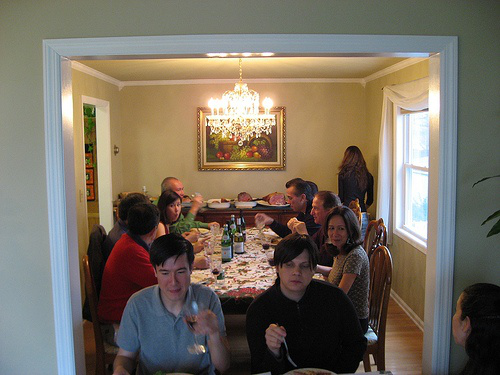

In [15]:
image=open_image(dirs_train_jpeg/'000222.jpg');
image

In [16]:
def displaying_image(im,ax=None,figsize=None):
    if not ax:
        fig,ax=plt.subplots(figsize=figsize)
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        return ax

In [17]:
def outlining_text(plt_ob,line_width): #for increasing legibility
    plt_ob.set_path_effects([patheffects.Stroke(linewidth=line_width,foreground='black'),patheffects.Normal()])

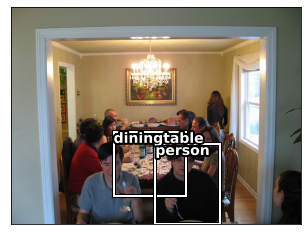

In [18]:
def draw_box(ax,box):
    patch=ax.add_patch(patches.Rectangle(box[:2],box[-2],box[-1],fill=False,edgecolor='white',lw=2))
    outlining_text(patch,4)
    
def adding_text(ax,xy,txt,sz=14):
    text=ax.text(*xy,txt,verticalalignment='top',color='white',fontsize=sz,weight='bold')
    outlining_text(text,4)
   
im=Image.open(dirs_train_jpeg/'000222.jpg') #opened using Pillow to avoid error
ax=displaying_image(im)
bbox_1=annotation_dict[222][0][0]
bbox_1=bbw_back(bbox_1)
bbox_2=annotation_dict[222][1][0]
bbox_2=bbw_back(bbox_2)
cat_id_222_1=annotation_dict[222][0][1]
cat_id_222_2=annotation_dict[222][1][1]
#for box1
draw_box(ax,bbox_1)
adding_text(ax,bbox_1[:2],cats_dict[cat_id_222_1])
#for box2
draw_box(ax,bbox_2)
adding_text(ax,bbox_2[:2],cats_dict[cat_id_222_2])

000047.jpg


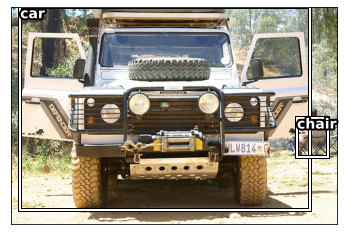

In [19]:
def draw_image(im,ann):
    ax=displaying_image(im)
    for b,c in ann:
        b=bbw_back(b)
        draw_box(ax,b)
        adding_text(ax,b[:2],cats_dict[c])
        
def draw_from_index(i):
    im_data=annotation_dict[i]
    file_image=image_dict[i]
    print(file_image)
    im=Image.open(dirs_train_jpeg/file_image)
    draw_image(im,im_data)
    
draw_from_index(47)

In [20]:
def largest_box(b): #finding biggest bbox to start with
    if not b: raise Exception()
    b= sorted(b,key=lambda x: np.product(x[0][-2:]-x[0][:2]),reverse=True)
    return b[0]


In [21]:
annotation_dict_large={a: largest_box(b) for a,b in annotation_dict.items()}
annotation_dict_large

{12: (array([ 96, 155, 269, 350]), 7),
 17: (array([ 77,  89, 335, 402]), 13),
 23: (array([  1,   2, 461, 242]), 15),
 26: (array([124,  89, 211, 336]), 7),
 32: (array([ 77, 103, 182, 374]), 1),
 33: (array([106,   8, 262, 498]), 1),
 34: (array([166, 115, 399, 359]), 19),
 35: (array([ 97, 217, 317, 464]), 15),
 36: (array([ 78,  26, 343, 318]), 12),
 42: (array([ 31, 262, 294, 499]), 19),
 44: (array([  0,   0, 329, 369]), 9),
 47: (array([  0,  14, 311, 458]), 7),
 48: (array([  0,   1, 499, 301]), 15),
 61: (array([ 10, 273, 278, 436]), 4),
 64: (array([ 22,   0, 499, 450]), 3),
 66: (array([181, 241, 258, 273]), 15),
 73: (array([142, 120, 459, 374]), 16),
 77: (array([  0,   1, 332, 305]), 8),
 78: (array([ 74,  14, 411, 474]), 12),
 83: (array([ 32, 108, 308, 446]), 7),
 89: (array([ 50,  21, 290, 316]), 9),
 91: (array([240, 124, 283, 194]), 7),
 104: (array([  6,   1, 332, 282]), 15),
 112: (array([173,  69, 327, 276]), 12),
 122: (array([ 19,  35, 473, 429]), 8),
 129: (arr

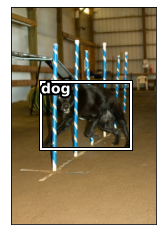

In [22]:
def draw_large_from_index(i):    #displaying images with largest box with index
    im_data=annotation_dict_large[i]
    file_image=image_dict[i]
    im=Image.open(dirs_train_jpeg/file_image)
    ax=displaying_image(im)
    b=im_data[0]
    b=bbw_back(b)
    draw_box(ax,b)
    c=im_data[1]
    adding_text(ax,b[:2],cats_dict[c])
    
draw_large_from_index(112)

In [23]:
(PATH/'tmp').mkdir(exist_ok=True)

In [24]:
csv_file=(PATH/'tmp'/'filename_and_cat.csv')

In [25]:
df=pd.DataFrame({'file_name': [image_dict[i] for i in training_image],
                 'Category': [cats_dict[annotation_dict_large[i][1]] for i in training_image] })
df.to_csv(csv_file,index=False)


In [26]:
f_model='resnet50'
sz=224
bs=64

In [27]:
??(ImageDataBunch)

Object `` not found.


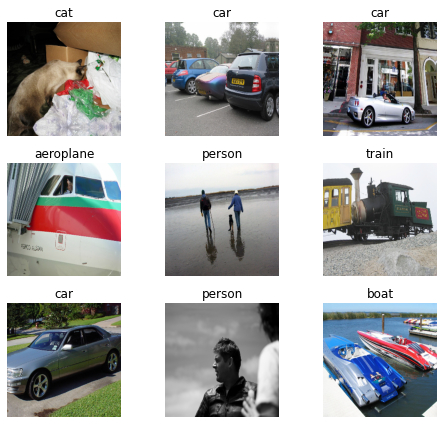

In [28]:
bs=64
data_im=   (ImageList.from_csv(path=PATH,folder='VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages',csv_name=csv_file,)
        .split_by_rand_pct()
        .label_from_df(cols='Category')
        .transform(get_transforms(), resize_method=ResizeMethod.SQUISH, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats)
        )

data_im.show_batch(rows=3, figsize=(7,6))

In [29]:
print(data_im.classes)
len(data_im.classes),data_im.c

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


(20, 20)

In [30]:
learn = cnn_learner(data_im, models.resnet50, metrics=error_rate)

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


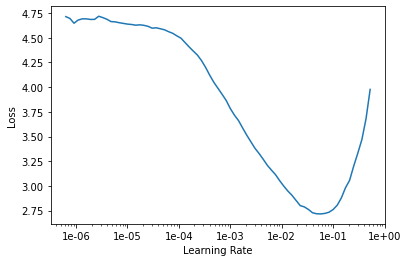

In [32]:
learn.recorder.plot()



In [31]:
lr = 5e-03
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.820659,1.093252,0.224000,00:29
1,1.221547,0.957217,0.258000,00:28
2,0.862770,0.787327,0.214000,00:28
3,0.606144,0.749412,0.190000,00:28
4,0.445080,0.742888,0.188000,00:28


In [32]:
learn.save("Phase1")


In [33]:
learn.load("Phase1")

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,car,aeroplane
Path: /content/drive/My Drive/Colab;

Valid: LabelList (500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
motorbike,tvmonitor,person,bus,person
Path: /content/drive/My Drive/Colab;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

In [34]:
learn.fit_one_cycle(1,slice(lr/100))

epoch,train_loss,valid_loss,error_rate,time
0,0.251023,0.738432,0.184000,00:29


In [35]:
learn.save("Phase-2")

In [39]:
learn.load("Phase-2")

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,car,aeroplane
Path: /content/drive/My Drive/Colab;

Valid: LabelList (500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
motorbike,tvmonitor,person,bus,person
Path: /content/drive/My Drive/Colab;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

In [40]:
data_im.train_ds

LabelList (2001 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
car,horse,person,car,aeroplane
Path: /content/drive/My Drive/Colab

In [41]:
image=open_image(PATH/'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000075.jpg');
label_first,label_second,label_third=learn.predict(image)
print(label_first)

dog


In [42]:

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_im.valid_ds)==len(losses)==len(idxs)

True

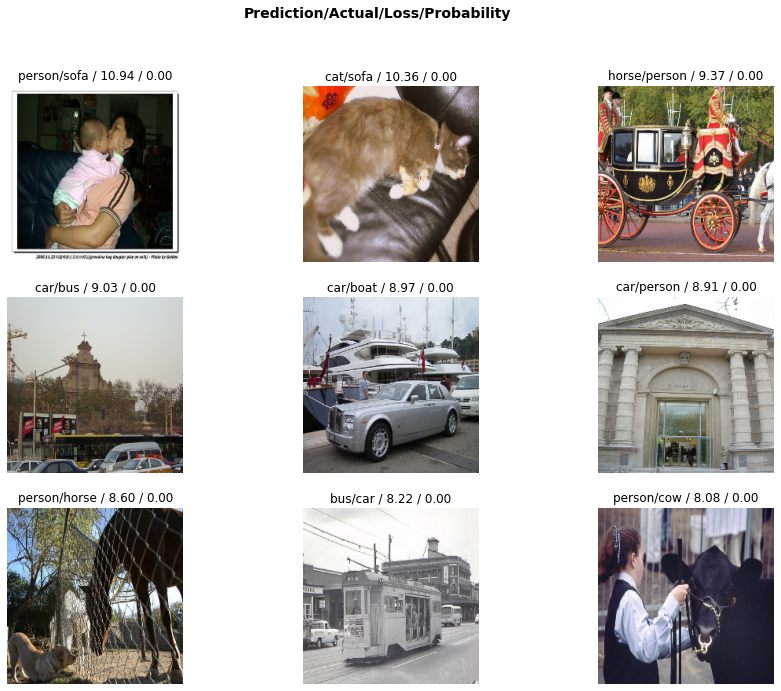

In [43]:

interp.plot_top_losses(9, figsize=(15,11))

**Phase-2**

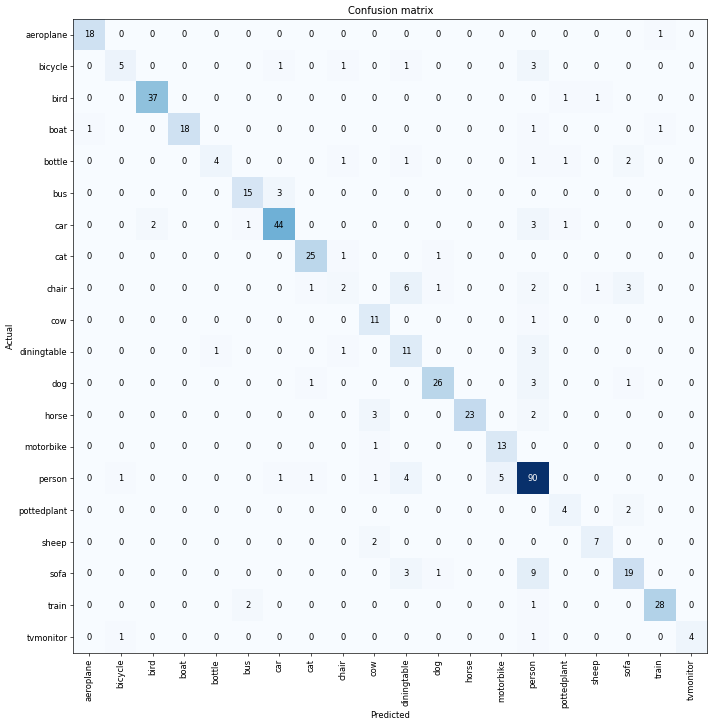

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [92]:
learn.load("Phase-1")
interp = ClassificationInterpretation.from_learner(learn)

**Phase-1**

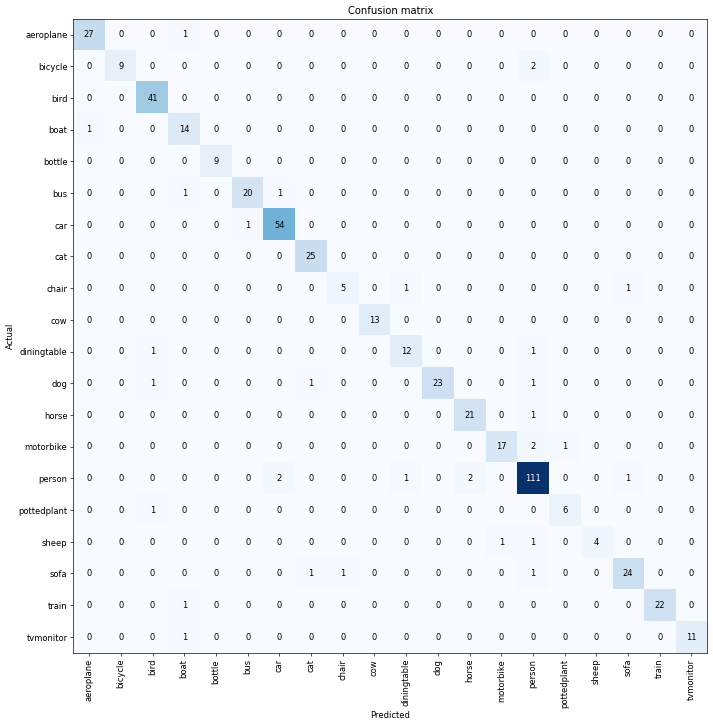

In [45]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

**BBOX**


In [46]:
Bbox_csv=PATH/'tmp/bb.csv'


In [47]:
tmp_bb=np.array([annotation_dict_large[i][0] for i in training_image])
bb_final= (' '.join(str(p) for p in o)for o in tmp_bb)

In [48]:
df_2=pd.DataFrame({'File_Name':[image_dict[o] for o in training_image],
                   'Bbox':bb_final})

In [49]:
df_2.to_csv(Bbox_csv,index=False)

In [50]:
Bbox_csv.open().readlines()[:5]
def labeling(fn_name):
    tmp_bb_1=df_2[df_2['File_Name']==str(fn_name).split("/")[-1]].Bbox.values[0]
    Coord=[float(o) for o in tmp_bb_1.split()]
    return tensor([Coord[0],Coord[1]],[Coord[2],Coord[3]])

In [51]:

data = (PointsItemList.from_csv(PATH,Bbox_csv, folder='VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages')
        .split_by_rand_pct()
        .label_from_func(labeling)
        .transform(tfm_y=True,size=(224,224))
        .databunch(bs=bs).normalize(imagenet_stats))


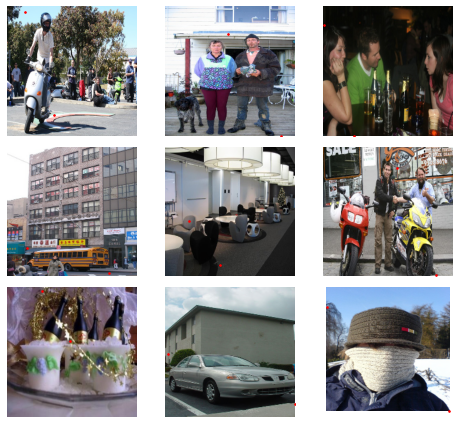

In [52]:
data.show_batch(rows=3, figsize=(7,6))

In [93]:
learn_reg = cnn_learner(data, models.resnet50, metrics=error_rate)

In [54]:
learn_reg.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


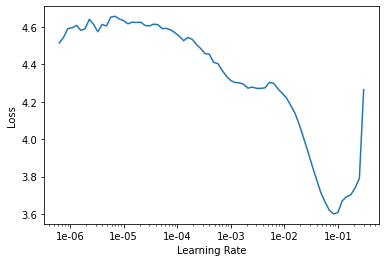

In [55]:
learn_reg.recorder.plot()

In [94]:
lr=2e-2
learn_reg.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,3.450733,0.655748,1.000000,00:23
1,1.480203,0.167341,1.000000,00:24
2,0.788223,0.140350,1.000000,00:23
3,0.468521,0.106487,1.000000,00:24
4,0.303567,0.097916,1.000000,00:24


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


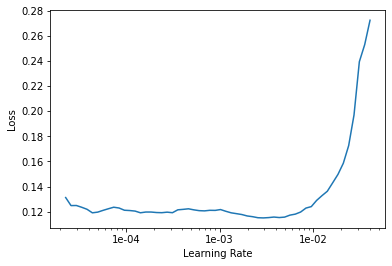

In [95]:
learn_reg.save("reg-1")
lrs = np.array([lr/100,lr/10,lr])
learn_reg.freeze_to(-2)
lrf=learn_reg.lr_find(lrs/1000)
learn_reg.recorder.plot(1)

In [96]:
learn_reg.fit_one_cycle(3,slice(lr/1000))

epoch,train_loss,valid_loss,error_rate,time
0,0.124810,0.097038,1.000000,00:25
1,0.122304,0.096015,1.000000,00:24
2,0.120664,0.095720,1.000000,00:25


In [97]:
learn_reg.save("reg-2")
learn_reg.unfreeze()
learn_reg.fit_one_cycle(2,lr/100)


epoch,train_loss,valid_loss,error_rate,time
0,0.120269,0.092774,1.000000,00:26
1,0.102732,0.084232,1.000000,00:26


In [98]:
learn_reg.save('reg-3')

In [102]:
learn_reg.load("reg-3")

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: PointsItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: PointsLabelList
ImagePoints (224, 224),ImagePoints (224, 224),ImagePoints (224, 224),ImagePoints (224, 224),ImagePoints (224, 224)
Path: /content/drive/My Drive/Colab;

Valid: LabelList (500 items)
x: PointsItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: PointsLabelList
ImagePoints (224, 224),ImagePoints (224, 224),ImagePoints (224, 224),ImagePoints (224, 224),ImagePoints (224, 224)
Path: /content/drive/My Drive/Colab;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=Fa

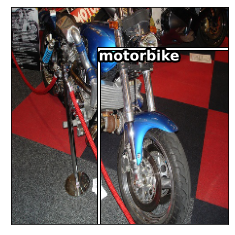

In [103]:
def show_rectangle(idx):
    a=data.valid_ds[idx]
    first,second,third=learn_reg.predict(a[0])
    label_first,label_second,label_third=learn.predict(a[0])
    box=[]
    for coord in second:
        for ele in coord:
            final_cvt=lambda x: (x+1)*224
            box.append(final_cvt(ele))
    ax=displaying_image(a[0].data.permute(1,2,0))
    box=bbw_back(box)
    draw_box(ax,box)
    adding_text(ax,box[:2],str(label_first))

show_rectangle(3)

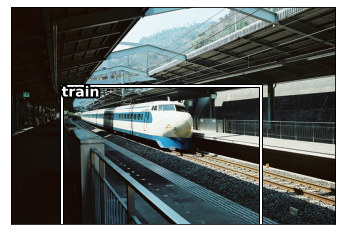

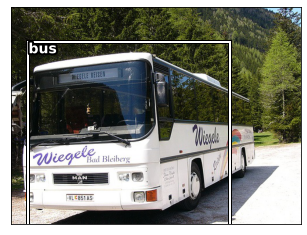

In [108]:
def from_im_path(path_im):
    img=open_image(path_im)
    im=Image.open(path_im)
    #a=data.valid_ds[]
    first,second,third=learn_reg.predict(img)
    label_first,label_second,label_third=learn.predict(img)
    #print(label_first,label_second)
    box=[]
    for coord in second:
        for ele in coord:
            final_cvt=lambda x: (x+1)*224
            box.append(final_cvt(ele))
    ax=displaying_image(im)
    box=bbw_back(box)
    draw_box(ax,box)
    adding_text(ax,box[:2],str(label_first))

#image from test data
from_im_path(PATH/'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000511.jpg')
from_im_path(PATH/'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000512.jpg')



**EXPORTING THE MODEL**

In [109]:
learn_reg.export('myModel_reg.pkl')
learn.export('myModel_im.pkl')

In [110]:
learn_reg=load_learner(PATH,'myModel_reg.pkl')
learn=load_learner(PATH,'myModel_im.pkl')

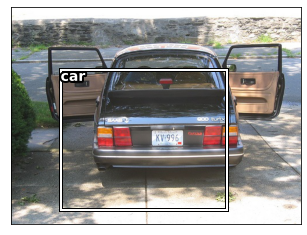

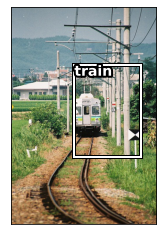

In [116]:
from_im_path(PATH/'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000074.jpg')
from_im_path(PATH/'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000002.jpg')